In [ ]:
!pip install diffusers==0.2.4
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 5.0 MB/s 
     |████████████████████████████████| 120 kB 31.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.0 MB/s 


In [ ]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

In [ ]:
# make sure you're logged in with `huggingface-cli login`
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

0it [00:00, ?it/s]

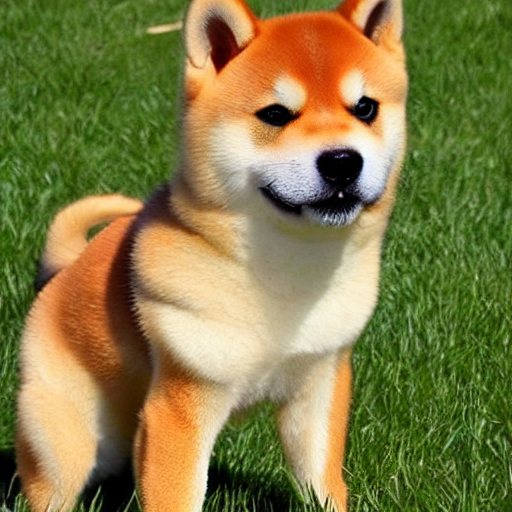

In [ ]:
prompt = 'Cute shiba inu dog'
with autocast(device):
  image = pipe(prompt)['sample'][0]
image

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

0it [00:00, ?it/s]

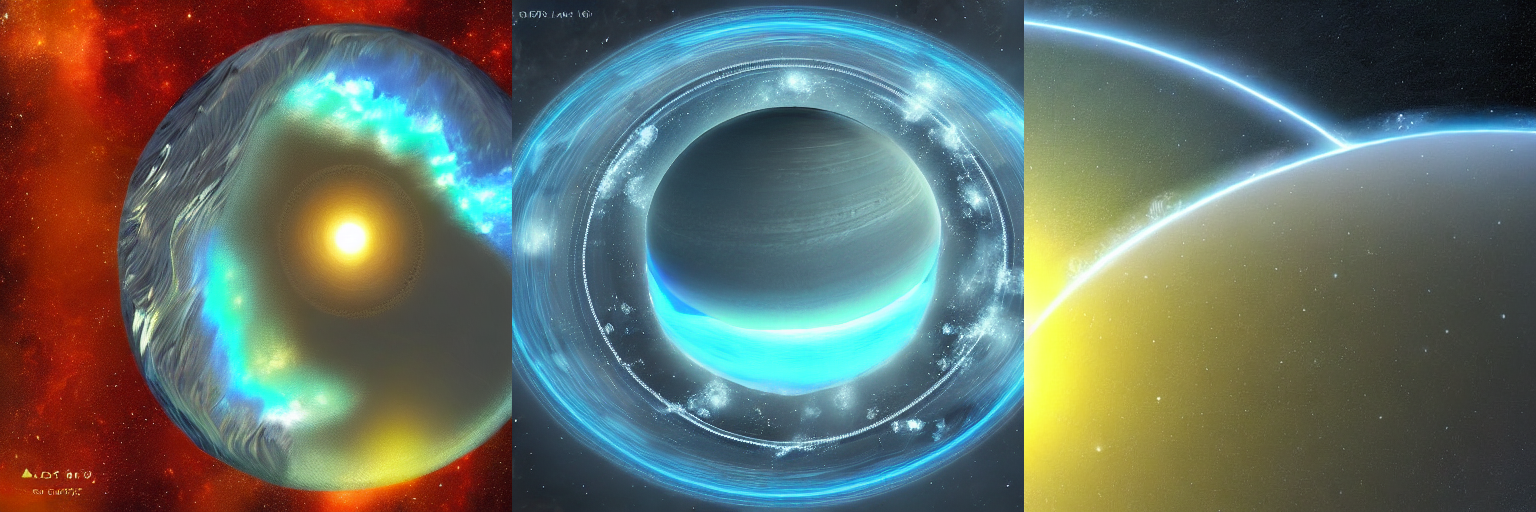

In [ ]:
n_images = 3
prompts = ['Planet scale halo of water in space digital art, Trending on ArtStation'] * n_images
with autocast(device):
  images = pipe(prompts, num_inference_steps=50)['sample']
image_grid(images, rows=1, cols=3)

## Image Generation Custom Pipeline

In [ ]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='vae', use_auth_token=True)
vae = vae.to(device)

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    'CompVis/stable-diffusion-v1-4', subfolder='unet', use_auth_token=True)
unet = unet.to(device)

# 4. Create a scheduler for inference
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085, beta_end=0.012,
    beta_schedule='scaled_linear', num_train_timesteps=1000)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.15.mlp.fc2.bias', 'vision_model.encoder.layers.20.self_attn.out_proj.weight', 'vision_model.encoder.layers.14.mlp.fc2.weight', 'vision_model.encoder.layers.22.mlp.fc1.weight', 'vision_model.encoder.layers.17.mlp.fc2.weight', 'vision_model.encoder.layers.14.self_attn.k_proj.bias', 'vision_model.encoder.layers.16.self_attn.out_proj.bias', 'vision_model.encoder.layers.4.layer_norm1.weight', 'vision_model.encoder.layers.9.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.self_attn.v_proj.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.weight', 'vision_model.encoder.layers.3.self_attn.k_proj.bias', 'vision_model.encoder.layers.23.layer_norm1.weight', 'vision_model.encoder.layers.20.self_attn.k_proj.bias', 'vision_model.encoder.layers.17.self_attn.q_proj.bias', 'vision_model.encoder.layers.15.self_attn.v_proj.weight', 'vision_model.

In [ ]:
def get_text_embeds(prompt):
  # Tokenize text and get embeddings
  text_input = tokenizer(
      prompt, padding='max_length', max_length=tokenizer.model_max_length,
      truncation=True, return_tensors='pt')
  with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

  # Do the same for unconditional embeddings
  uncond_input = tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=tokenizer.model_max_length, return_tensors='pt')
  with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

  # Cat for final embeddings
  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

# test_embeds = get_text_embeds(['cute dog'])
# print(test_embeds)
# print(test_embeds.shape)

In [ ]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']

  return latents

# test_latents = produce_latents(test_embeds)
# print(test_latents)
# print(test_latents.shape)

In [ ]:
def decode_img_latents(latents):
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    imgs = vae.decode(latents)

  imgs = (imgs / 2 + 0.5).clamp(0, 1)
  imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
  imgs = (imgs * 255).round().astype('uint8')
  pil_images = [Image.fromarray(image) for image in imgs]
  return pil_images

# imgs = decode_img_latents(test_latents)
# imgs[0]

In [ ]:
def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)

  # Img latents -> imgs
  imgs = decode_img_latents(latents)

  return imgs

0it [00:00, ?it/s]

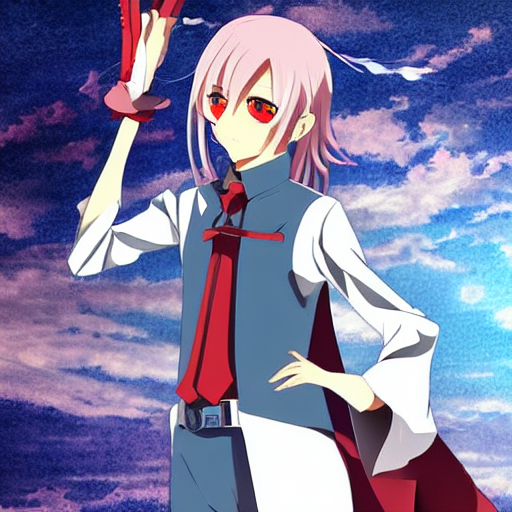

In [ ]:
prompt_to_img('Super cool anime character', 512, 512, 20)[0]